# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.deblend import GalaxyEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep_pjw as sep

from bliss.datasets.lsst import BACKGROUND

In [ ]:
def asinh_map(x, q=0.01, stretch=1, minimum=0):
    return np.arcsinh(q * (x - minimum) / stretch) / q

In [ ]:
device = torch.device("cuda:0")
TILE_SLEN = 4
PTILE_SLEN = 52
BP = 24
SLEN = 40

In [ ]:
# model
ae_path = "../../models/autoencoder_42_42.pt"
deblend = GalaxyEncoder(ae_path, lr=1e-4).to(device).eval()
_ = deblend.load_state_dict(
    torch.load(f"../../models/deblender_42_42.pt", map_location=device, weights_only=True)
)
deblend = deblend.requires_grad_(False)

In [ ]:
# data
from bliss.datasets.io import load_dataset_npz

test_ds = load_dataset_npz("../../data/datasets/test_ds_42.npz")
test_ds.keys()

dict_keys(['images', 'noiseless', 'uncentered_sources', 'centered_sources', 'paddings', 'fluxes', 'star_bools', 'plocs', 'n_sources', 'galaxy_params', 'star_fluxes', 'galaxy_bools'])

In [ ]:
# use 1000 images for now to speedup iteration time
# NOTE: paddings and single_centered / single_uncentered by default both have stars and galaxies
# easiest is to remove stars in `single_centered` and `single_uncentered` from the get go to
# avoid errors
test_ds_sample = {p: q[:1000] for p, q in test_ds.items()}
images = test_ds_sample["images"]
paddings = test_ds_sample['paddings']
noiseless = test_ds_sample['noiseless']

_tgbools = rearrange(test_ds_sample['galaxy_bools'], 'n ms 1 -> n ms 1 1 1 ')
galaxy_centered = test_ds_sample['centered_sources'] * _tgbools
galaxy_uncentered = test_ds_sample['uncentered_sources'] * _tgbools


images.shape, paddings.shape, galaxy_uncentered.shape

(torch.Size([1000, 1, 88, 88]),
 torch.Size([1000, 1, 88, 88]),
 torch.Size([1000, 10, 1, 88, 88]))

In [ ]:
# snrs = torch.zeros_like(test_ds_sample['fluxes'])
# n_batches = test_ds_sample['n_sources'].shape[0]
# for ii in range(n_batches):
#     n_sources =  test_ds_sample['n_sources'][ii].item()
#     for jj in range(n_sources):
#         image = single_centered[ii, jj, 0, :, :].numpy()
#         flux, fluxerr, _ = sep.sum_circle(image, [43.5], [43.5], 5.0, err=BACKGROUND.sqrt())
#         snrs[ii, jj, 0] = flux.item() / fluxerr.item()

# test_ds_sample['snr'] = snrs

In [ ]:
# get truth catalog
exclude = ("images", "uncentered_sources", "centered_sources", "noiseless", "paddings")
slen = images.shape[-1] - 2 * BP
true_cat_dict = {p: q for p, q in test_ds_sample.items() if p not in exclude}
_truth = FullCatalog(slen, slen, true_cat_dict)


In [ ]:
# NOTE: Need to do this BEFORE removing multiple sources in one tile below. 
# otherwise the single_centered images are not aligned with the catalog!
# might be interesting to remember that converting to tile_params and then to full catalog 
# shuffles the positions of individual objects too.


# get true fluxes, fluxerr, snr
from einops import reduce

n_batches = _truth.n_sources.shape[0]

fluxes = torch.zeros((n_batches, _truth.max_n_sources, 1))
fluxerrs = torch.zeros((n_batches, _truth.max_n_sources, 1))
snrs = torch.zeros((n_batches, _truth.max_n_sources, 1))


for ii in range(n_batches):
    n_sources = _truth.n_sources[ii].item()
    _plocs = _truth.plocs[ii]
    # TODO: Should we remove the padding for this calculation? how about for detections?
    image = images[ii, 0] - paddings[ii, 0]
    y = _plocs[:, 0].numpy() + BP - 0.5
    x = _plocs[:, 1].numpy() + BP - 0.5

    # we obtain new 'residual images' which consist of subtracting every galaxy except one 
    # from full images 
    each_galaxy = galaxy_uncentered[ii, :, 0]  # n h w
    all_galaxies = rearrange(reduce(each_galaxy, 'n h w -> h w', 'sum'), 'h w -> 1 h w')
    other_galaxies = all_galaxies - each_galaxy
    residual_images = rearrange(image, 'h w -> 1 h w') - other_galaxies

    _fluxes = [] 
    _fluxerrs = [] 
    for jj in range(n_sources):
        f, ferr, _ = sep.sum_circle(residual_images[jj].numpy(), [x[jj]], [y[jj]], 5.0, err=BACKGROUND.sqrt().item())
        _fluxes.append(f.item())
        _fluxerrs.append(ferr.item())

    
    fluxes[ii, :n_sources, 0] = torch.tensor(_fluxes)
    fluxerrs[ii, :n_sources, 0] = torch.tensor(_fluxerrs)
    snrs[ii, :n_sources, 0] = torch.tensor(_fluxes) / torch.tensor(_fluxerrs)

_truth['fluxes_sep'] = fluxes
_truth['fluxerrs'] = fluxerrs
_truth['snr'] = snrs

In [ ]:
# sanity check
idx = 9
galaxy_centered[idx, :, 0].sum(axis=(-1, -2)), _truth['fluxes'][idx, :, 0], _truth['fluxes_sep'][idx, :, 0]

(tensor([12320.1973, 20327.4062,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000]),
 tensor([12343., 20365.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.]),
 tensor([14828.4551, 16603.0059,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000]))

In [ ]:
x.shape, y.shape

((10,), (10,))

In [ ]:
# add blendedness
x = galaxy_uncentered[:, :, 0]
y = noiseless[:, 0]
num = reduce(x * x, "b s h w -> b s", "sum")
denom = reduce(rearrange(y, 'b h w -> b 1 h w') * x, "b s h w -> b s", "sum")
blendedness = 1 - num / denom
_truth['blendedness'] = rearrange(blendedness, 'b s -> b s 1')

(array([1507.,  389.,  226.,  180.,  141.,  126.,  104.,   88.,   80.,
          89.]),
 array([1.15036964e-05, 9.94003266e-02, 1.98789150e-01, 2.98177958e-01,
        3.97566795e-01, 4.96955603e-01, 5.96344411e-01, 6.95733249e-01,
        7.95122087e-01, 8.94510865e-01, 9.93899703e-01]),
 <BarContainer object of 10 artists>)

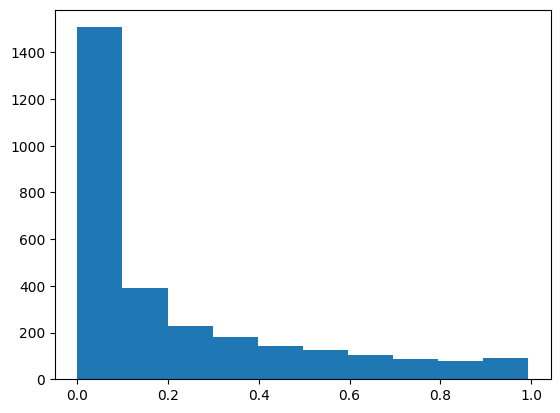

In [ ]:
bl = _truth['blendedness'].flatten()
mask = bl > 0
plt.hist(bl[mask])

In [ ]:
truth_tile_cat = _truth.to_tile_params(TILE_SLEN, ignore_extra_sources=True)
truth = truth_tile_cat.to_full_params() # so we can flatten and catalogs are exactly aligned
truth_tile_cat.locs.shape

torch.Size([1000, 10, 10, 2])

In [ ]:
# check correctness
idx = 5
truth['fluxes_sep'][idx] , truth['fluxes'][idx], truth['snr'][idx]

(tensor([[ 40162.2656],
         [164062.2812],
         [  6407.5234],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000]]),
 tensor([[ 47940.],
         [204648.],
         [ 14634.],
         [     0.],
         [     0.],
         [     0.],
         [     0.],
         [     0.],
         [     0.],
         [     0.]]),
 tensor([[10.5789],
         [43.2476],
         [ 1.6873],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]))

In [ ]:
# difference thanks to objects whose centroids fall in the same tile. 
# should compare with latter one
_truth.n_sources.sum(), truth.n_sources.sum()

(tensor(3208), tensor(3160))

# Use true centroid and galaxy detections

In [ ]:
# run binary encoder on true locations
batch_size = 50
n_images = images.shape[0]
n_batches = math.ceil(n_images / batch_size)

tiled_gparams = [] 

for ii in tqdm(range(n_batches)):
    start, end = ii*50, (ii+1)*50
    bimages = images[start:end].to(device)
    btile_locs = truth_tile_cat.locs[start:end].to(device)
    _tile_gparams = deblend.variational_mode(bimages, btile_locs).to('cpu')
    tiled_gparams.append(_tile_gparams)

tile_gparams = torch.concatenate(tiled_gparams, axis=0) * truth_tile_cat['galaxy_bools']
tile_gparams.shape

100%|██████████| 20/20 [00:00<00:00, 36.32it/s]


torch.Size([1000, 10, 10, 8])

In [ ]:
# create new catalog with these booleans and prob
from copy import deepcopy
est_tiled = deepcopy(truth_tile_cat.to_dict())
est_tiled['galaxy_params'] = tile_gparams

est_tiled_cat = TileCatalog(TILE_SLEN, est_tiled)
est = est_tiled_cat.to_full_params()

In [ ]:
# now we need to get full sized images with each individual galaxy, in the correct location. 
# this is so we can measure flux on images that have every galaxy except one subtracted
# this seems difficult given our current functions
# we can actually cleverly zero out galaxy_bools to achieve this
from copy import deepcopy

from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles

batch_size = 50
n_images = images.shape[0]
n_batches = math.ceil(n_images / batch_size)


recon_uncentered = torch.zeros((n_images, est.max_n_sources, 1, images.shape[-2], images.shape[-1]))

for ii in tqdm(range(est.max_n_sources)):
    # get mask
    mask = torch.arange(est.max_n_sources)
    mask = mask[mask!=ii]

    # make a copy
    est_ii = FullCatalog(SLEN, SLEN, deepcopy(est.to_dict()))
    est_ii['galaxy_bools'][:, mask, :] = 0.
    est_ii['galaxy_bools'] = est_ii['galaxy_bools'].contiguous()
    est_tiled_ii = est_ii.to_tile_params(TILE_SLEN, ignore_extra_sources=True)

    images_ii = []
    for jj in range(n_batches):
        start, end = jj*50, (jj+1)*50
        blocs = est_tiled_ii.locs[start:end].to(device)
        bgparams = est_tiled_ii['galaxy_params'][start:end].to(device)
        bgbools = est_tiled_ii['galaxy_bools'][start:end].to(device)


        galaxy_tiles = render_galaxy_ptiles(deblend._dec, blocs, bgparams, bgbools, PTILE_SLEN, TILE_SLEN).to('cpu')

        galaxy_images = reconstruct_image_from_ptiles(galaxy_tiles, TILE_SLEN)
        images_ii.append(galaxy_images)
    
    images_ii = torch.concatenate(images_ii, axis=0)
    recon_uncentered[:, ii, :, :, :] = images_ii



100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


In [ ]:
idx = 1
recon_uncentered[idx].sum(axis=(-1, -2)), truth['fluxes'][idx], truth['galaxy_bools'][idx]

(tensor([[ 19812.3457],
         [ 64738.2305],
         [ 18670.8848],
         [ 12448.4238],
         [175281.5625],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000],
         [     0.0000]]),
 tensor([[ 47641.],
         [ 34415.],
         [ 42460.],
         [ 14458.],
         [210191.],
         [     0.],
         [     0.],
         [     0.],
         [     0.],
         [     0.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [ ]:
# get estimated SNR both for blended and deblended images

# first blended
from copy import deepcopy

est_blended = FullCatalog(SLEN, SLEN, deepcopy(truth.to_dict()))
n_batches = est_blended.n_sources.shape[0]

fluxes = torch.zeros((n_batches, truth.max_n_sources, 1))
fluxerrs = torch.zeros((n_batches, truth.max_n_sources, 1))

for ii in range(n_batches):
    n_sources = truth.n_sources[ii].item()
    _plocs = truth.plocs[ii]
    y = _plocs[:, 0].numpy() + BP - 0.5
    x = _plocs[:, 1].numpy() + BP - 0.5
    # TODO: Should we remove the padding for this calculation?
    image = images[ii, 0] - paddings[ii, 0]
    flux, fluxerr, _ = sep.sum_circle(image.numpy(), x, y, 5.0, err=BACKGROUND.sqrt().item())
    
    fluxes[ii, :n_sources, 0] = torch.from_numpy(flux)[:n_sources]
    fluxerrs[ii, :n_sources, 0] = torch.from_numpy(fluxerr)[:n_sources]

est_blended['fluxes_sep'] = fluxes
est_blended['fluxerrs'] = fluxerrs

In [ ]:
# now deblended
n_batches = est_blended.n_sources.shape[0]

fluxes = torch.zeros((n_batches, truth.max_n_sources, 1))
fluxerrs = torch.zeros((n_batches, truth.max_n_sources, 1))

for ii in range(n_batches):
    n_sources = est.n_sources[ii].item()
    _plocs = est.plocs[ii]
    y = _plocs[:, 0].numpy() + BP - 0.5
    x = _plocs[:, 1].numpy() + BP - 0.5
    # TODO: Should we remove the padding for this calculation?
    image = images[ii, 0] - paddings[ii, 0]

    # we obtain new 'residual images' which consist of subtracting every galaxy except one 
    # from full images 
    each_galaxy = recon_uncentered[ii, :, 0] # n h w
    all_galaxies = rearrange(reduce(each_galaxy, 'n h w -> h w', 'sum'), 'h w -> 1 h w')
    other_galaxies = all_galaxies - each_galaxy
    residual_images = rearrange(image, 'h w -> 1 h w') - other_galaxies    


    _fluxes = [] 
    _fluxerrs = [] 
    for jj in range(n_sources):
        f, ferr, _ = sep.sum_circle(residual_images[jj].numpy(), [x[jj]], [y[jj]], 5.0, err=BACKGROUND.sqrt().item())
        _fluxes.append(f.item())
        _fluxerrs.append(ferr.item())

    
    fluxes[ii, :n_sources, 0] = torch.tensor(_fluxes)
    fluxerrs[ii, :n_sources, 0] = torch.tensor(_fluxerrs)

est['fluxes_sep'] = fluxes
est['fluxerrs'] = fluxerrs

In [ ]:
# some objects have negative snr (calculated via sep)
torch.sum((truth['galaxy_bools'] == 1 ) * (truth['snr'] < 0 ))

tensor(9)

In [ ]:
# now compare residuals of each of the three catalogs! 
# all should be aligned
mask = (truth['snr'].flatten() > 0) * (truth['galaxy_bools'].flatten() == 1)
mask = mask.bool()
snr = truth['snr'].flatten()[mask]
tfluxes = truth['fluxes_sep'].flatten()[mask]
efluxes = est['fluxes_sep'].flatten()[mask]
bl_fluxes = est_blended['fluxes_sep'].flatten()[mask]
bld = truth['blendedness'].flatten()[mask]

# deficiency due to snr < 0 objects
tfluxes.shape, bl_fluxes.shape

(torch.Size([2876]), torch.Size([2876]))

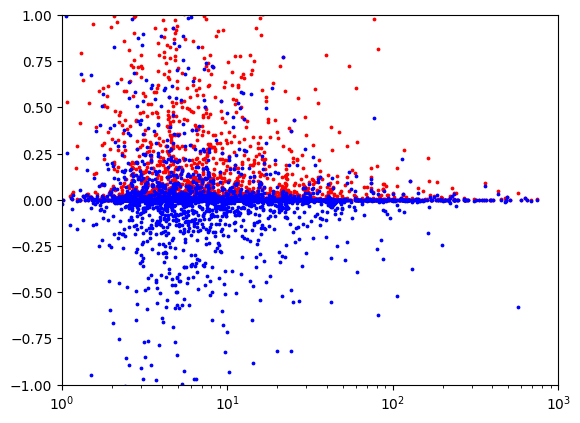

In [ ]:
res1 = (bl_fluxes - tfluxes) / tfluxes
res2 = (efluxes - tfluxes) / tfluxes
plt.scatter(snr, res1, marker='o', color='r', s=3)
plt.scatter(snr, res2, marker='o', color='b', s=3)
plt.ylim(-1.0, 1.0)
plt.xlim(1, 1000)
plt.xscale('log')

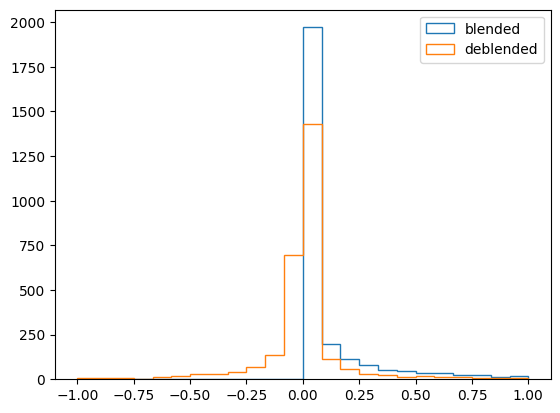

In [ ]:
bins = np.linspace(-1, 1, 25)
plt.hist(res1, label='blended', histtype='step', bins=bins)
plt.hist(res2, label='deblended', histtype='step', bins=bins)
plt.legend()

(0.01, 1)

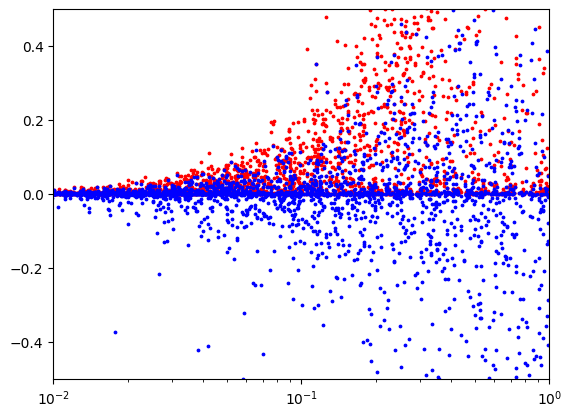

In [ ]:
res1 = (bl_fluxes - tfluxes) / tfluxes
res2 = (efluxes - tfluxes) / tfluxes
plt.scatter(bld, res1, marker='o', color='r', s=3)
plt.scatter(bld, res2, marker='o', color='b', s=3)
plt.xscale("log")
plt.ylim(-0.5, 0.5)
plt.xlim(1e-2, 1)


/home/imendoza/bliss/bliss/plotting.py:261: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


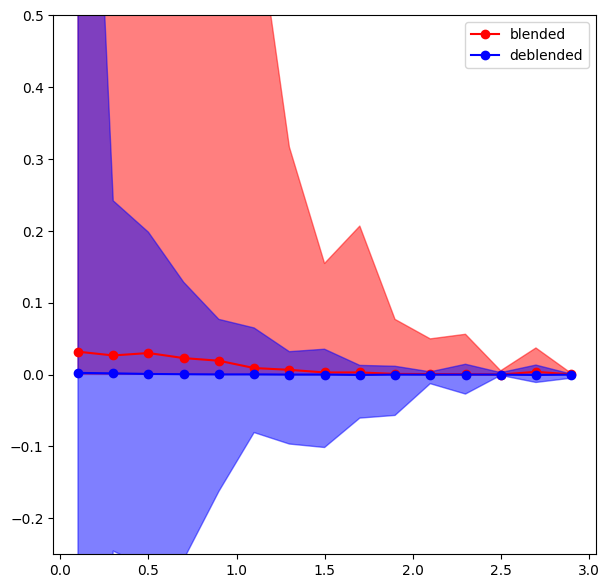

In [ ]:
from bliss.plotting import scatter_shade_plot

fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), res1, delta=0.2, alpha=0.5, qs=(0.1, 0.9), xlims=(0, 3), color='r', label='blended')
scatter_shade_plot(ax, snr.log10(), res2, delta=0.2, alpha=0.5, qs=(0.1, 0.9), xlims=(0, 3), color='b', label='deblended')
plt.ylim(-0.25, 0.5)
plt.legend()

In [ ]:
bins

tensor([-1.3377,  0.2743,  0.3866,  0.4505,  0.5018,  0.5407,  0.5868,  0.6304,
         0.6670,  0.7087,  0.7493,  0.7898,  0.8355,  0.8852,  0.9299,  0.9877,
         1.0442,  1.1220,  1.1967,  1.2855,  1.3888,  1.5356,  1.7073,  2.0241,
         3.5609])

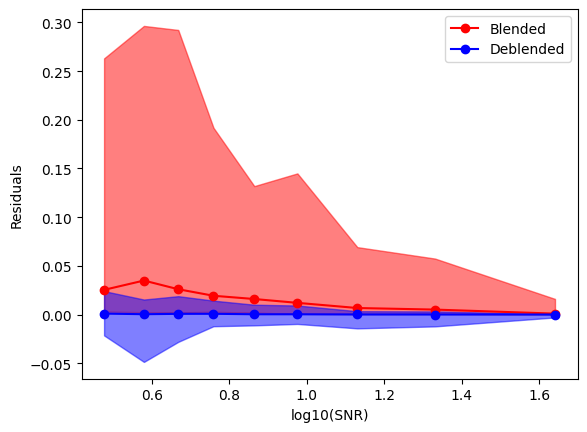

In [ ]:
# equally sized bins (to avoid uncertainty of number of sources)
# between 0 and 3 in log10(snr)
mask = (snr > 3) * (snr <= 1000)
_snr = snr[mask]
_snr_log = _snr.log10()
qs = torch.linspace(0, 1, 10)
bins = torch.quantile(_snr_log, qs).sort().values

def calculate_statistics(residuals, mask, bins):
    medians, q1s, q3s = [], [], []
    for ii in range(len(bins) - 1):
        mask2 = (_snr_log > bins[ii]) * (_snr_log < bins[ii+1])
        masked_residuals = residuals[mask][mask2]
        medians.append(torch.median(masked_residuals))
        q1s.append(torch.quantile(masked_residuals, 0.25))
        q3s.append(torch.quantile(masked_residuals, 0.75))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

# Calculate statistics for res1
medians1, q1s1, q3s1 = calculate_statistics(res1, mask, bins)
plt.plot(bins[:-1], medians1, marker='o', color='r', label='Blended')
plt.fill_between(bins[:-1], q1s1, q3s1, color='r', alpha=0.5)

# Calculate statistics for res2
medians2, q1s2, q3s2 = calculate_statistics(res2, mask, bins)
plt.plot(bins[:-1], medians2, marker='o', color='b', label='Deblended')
plt.fill_between(bins[:-1], q1s2, q3s2, color='b', alpha=0.5)

# Add labels and legend
plt.xlabel('log10(SNR)')
plt.ylabel('Residuals')
plt.legend()
plt.show()


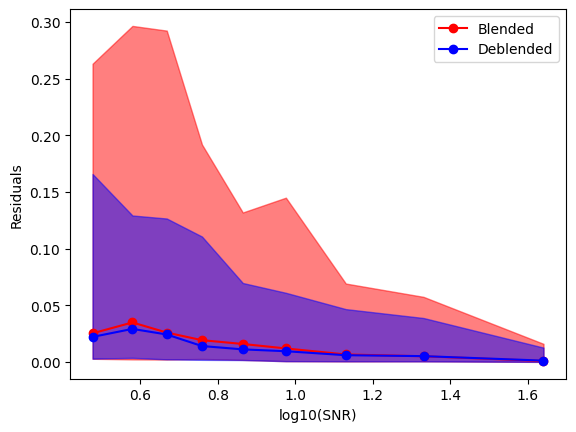

In [ ]:
# equally sized bins (to avoid uncertainty of number of sources)
# between 0 and 3 in log10(snr)
mask = (snr > 3) * (snr <= 1000)
_snr = snr[mask]
_snr_log = _snr.log10()
qs = torch.linspace(0, 1, 10)
bins = torch.quantile(_snr_log, qs).sort().values

def calculate_statistics(residuals, mask, bins):
    medians, q1s, q3s = [], [], []
    for ii in range(len(bins) - 1):
        mask2 = (_snr_log > bins[ii]) * (_snr_log < bins[ii+1])
        masked_residuals = residuals[mask][mask2]
        medians.append(torch.median(masked_residuals))
        q1s.append(torch.quantile(masked_residuals, 0.25))
        q3s.append(torch.quantile(masked_residuals, 0.75))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

# Calculate statistics for res1
medians1, q1s1, q3s1 = calculate_statistics(res1.abs(), mask, bins)
plt.plot(bins[:-1], medians1, marker='o', color='r', label='Blended')
plt.fill_between(bins[:-1], q1s1, q3s1, color='r', alpha=0.5)

# Calculate statistics for res2
medians2, q1s2, q3s2 = calculate_statistics(res2.abs(), mask, bins)
plt.plot(bins[:-1], medians2, marker='o', color='b', label='Deblended')
plt.fill_between(bins[:-1], q1s2, q3s2, color='b', alpha=0.5)

# Add labels and legend
plt.xlabel('log10(SNR)')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
mask = (snr > 3) * (snr <= 2000)
_snr = snr[mask]
_snr_log = _snr.log10()
qs = torch.linspace(0, 1, 10)
bins = torch.quantile(_snr_log, qs).sort().values

In [ ]:
bins

tensor([0.4771, 0.5801, 0.6691, 0.7601, 0.8661, 0.9785, 1.1331, 1.3334, 1.6464,
        3.2514])

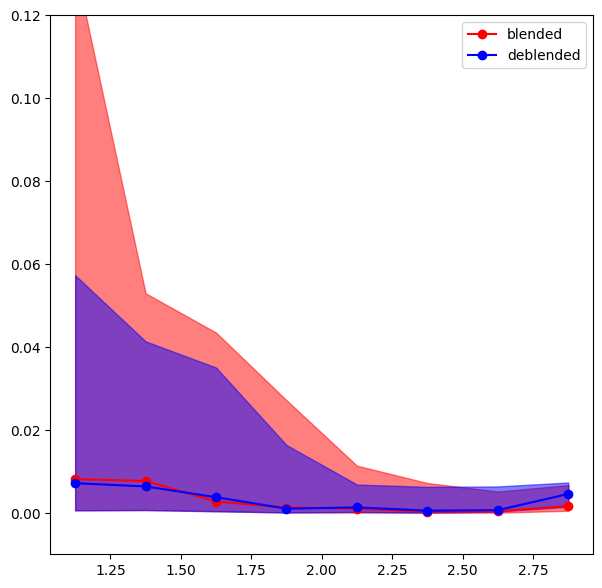

In [ ]:
# comparison with madness
from bliss.plotting import scatter_shade_plot

fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), res1.abs(), delta=0.25, alpha=0.5, qs=(0.25, 0.75), xlims=(1, 3), color='r', label='blended')
scatter_shade_plot(ax, snr.log10(), res2.abs(), delta=0.25, alpha=0.5, qs=(0.25, 0.75), xlims=(1, 3), color='b', label='deblended')
plt.ylim(-0.01, 0.12)
plt.legend()

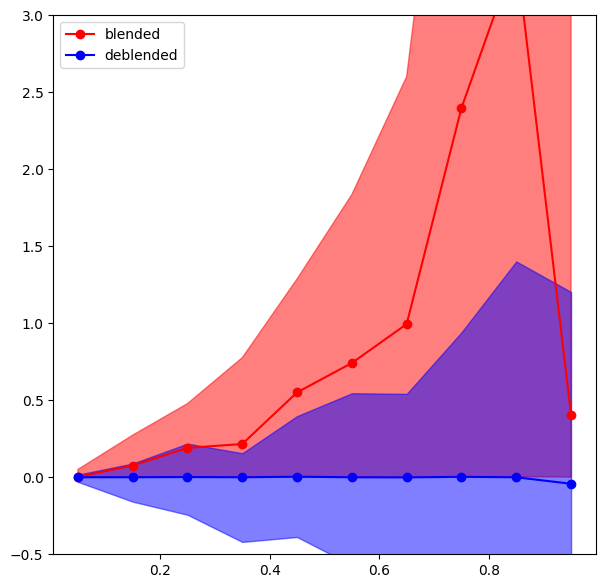

In [ ]:
# blendedness
from bliss.plotting import scatter_shade_plot

fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, bld, res1, delta=0.1, alpha=0.5, qs=(0.1, 0.9), xlims=(0, 3), color='r', label='blended')
scatter_shade_plot(ax, bld, res2, delta=0.1, alpha=0.5, qs=(0.1, 0.9), xlims=(0, 3), color='b', label='deblended')
plt.ylim(-0.5, 3.0)
plt.legend()

([<matplotlib.axis.XTick at 0x7fbccef8bf40>,
 [Text(0.01, 0, '$\\mathdefault{10^{-2}}$'),
  Text(0.1, 0, '$\\mathdefault{10^{-1}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$')])

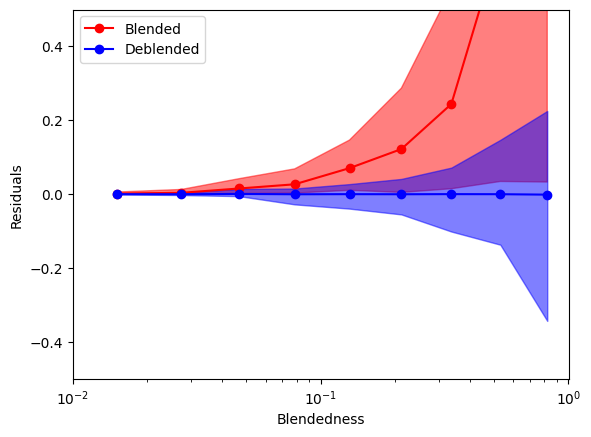

In [ ]:
# generate a plot just like the cell above but with blendedness
# equally sized bins (to avoid uncertainty of number of sources)
# between 1e-2 and 1 in blendedness

mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[mask]
qs = torch.linspace(0, 1, 10)
bins = torch.quantile(_bld, qs).sort().values

def calculate_statistics(residuals, mask, bins):
    medians, q1s, q3s = [], [], []
    for ii in range(len(bins) - 1):
        mask2 = (_bld > bins[ii]) * (_bld < bins[ii+1])
        masked_residuals = residuals[mask][mask2]
        medians.append(torch.median(masked_residuals))
        q1s.append(torch.quantile(masked_residuals, 0.25))
        q3s.append(torch.quantile(masked_residuals, 0.75))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

# Calculate statistics for res1
medians1, q1s1, q3s1 = calculate_statistics(res1, mask, bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, medians1, marker='o', color='r', label='Blended')
plt.fill_between(bin_centers, q1s1, q3s1, color='r', alpha=0.5)

# Calculate statistics for res2
medians2, q1s2, q3s2 = calculate_statistics(res2, mask, bins)
plt.plot(bin_centers, medians2, marker='o', color='b', label='Deblended')
plt.fill_between(bin_centers, q1s2, q3s2, color='b', alpha=0.5)

# Add labels and legend
plt.xlabel('Blendedness')
plt.ylabel('Residuals')
plt.legend()
plt.xscale('log')

plt.ylim(-0.5, 0.5)

# add tick for 1 (log(1) = 0)
plt.xticks([1e-2, 1e-1, 1])



([<matplotlib.axis.XTick at 0x7fbccf0980a0>,
 [Text(0.01, 0, '$\\mathdefault{10^{-2}}$'),
  Text(0.1, 0, '$\\mathdefault{10^{-1}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$')])

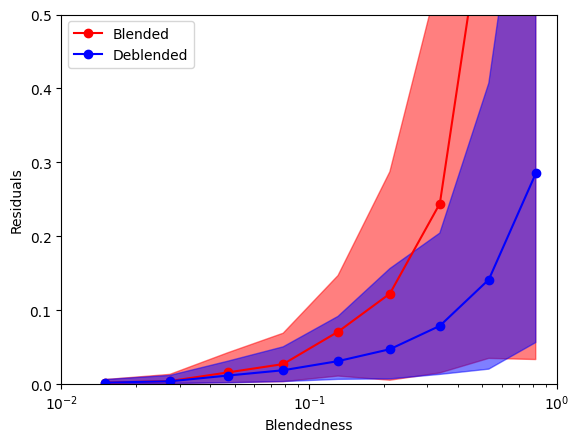

In [ ]:
# generate a plot just like the cell above but with blendedness
# equally sized bins (to avoid uncertainty of number of sources)
# between 1e-2 and 1 in blendedness

mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[mask]
qs = torch.linspace(0, 1, 10)
bins = torch.quantile(_bld, qs).sort().values

def calculate_statistics(residuals, mask, bins):
    medians, q1s, q3s = [], [], []
    for ii in range(len(bins) - 1):
        mask2 = (_bld > bins[ii]) * (_bld < bins[ii+1])
        masked_residuals = residuals[mask][mask2]
        medians.append(torch.median(masked_residuals))
        q1s.append(torch.quantile(masked_residuals, 0.25))
        q3s.append(torch.quantile(masked_residuals, 0.75))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

# Calculate statistics for res1
medians1, q1s1, q3s1 = calculate_statistics(res1.abs(), mask, bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, medians1, marker='o', color='r', label='Blended')
plt.fill_between(bin_centers, q1s1, q3s1, color='r', alpha=0.5)

# Calculate statistics for res2
medians2, q1s2, q3s2 = calculate_statistics(res2.abs(), mask, bins)
plt.plot(bin_centers, medians2, marker='o', color='b', label='Deblended')
plt.fill_between(bin_centers, q1s2, q3s2, color='b', alpha=0.5)

# Add labels and legend
plt.xlabel('Blendedness')
plt.ylabel('Residuals')
plt.legend()
plt.xscale('log')

plt.ylim(0, 0.5)

# add tick for 1 (log(1) = 0)
plt.xticks([1e-2, 1e-1, 1])


/home/imendoza/bliss/bliss/plotting.py:261: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


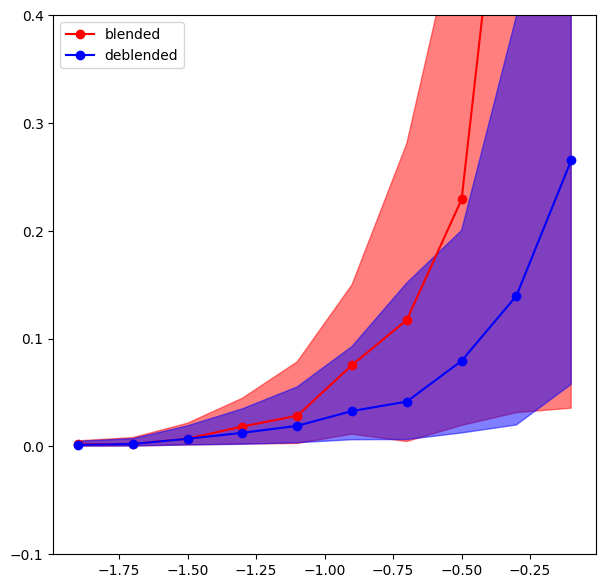

In [ ]:
# blendedness (madness)
from bliss.plotting import scatter_shade_plot

fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, bld.log10(), res1.abs(), delta=0.2, alpha=0.5, qs=(0.25, 0.75), xlims=(-2, 0), color='r', label='blended')
scatter_shade_plot(ax, bld.log10(), res2.abs(), delta=0.2, alpha=0.5, qs=(0.25, 0.75), xlims=(-2, 0), color='b', label='deblended')
plt.ylim(-0.1, 0.4)
plt.legend()

In [ ]:
# # check correctness
# idx = 11 # stars too
# centered_images[idx, :, 0, :, :].sum(axis=(-1, -2)), est['fluxes'][idx], est['galaxy_bools'][idx], truth['galaxy_bools'][idx], est.n_sources[idx]

## Example reconstructions

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


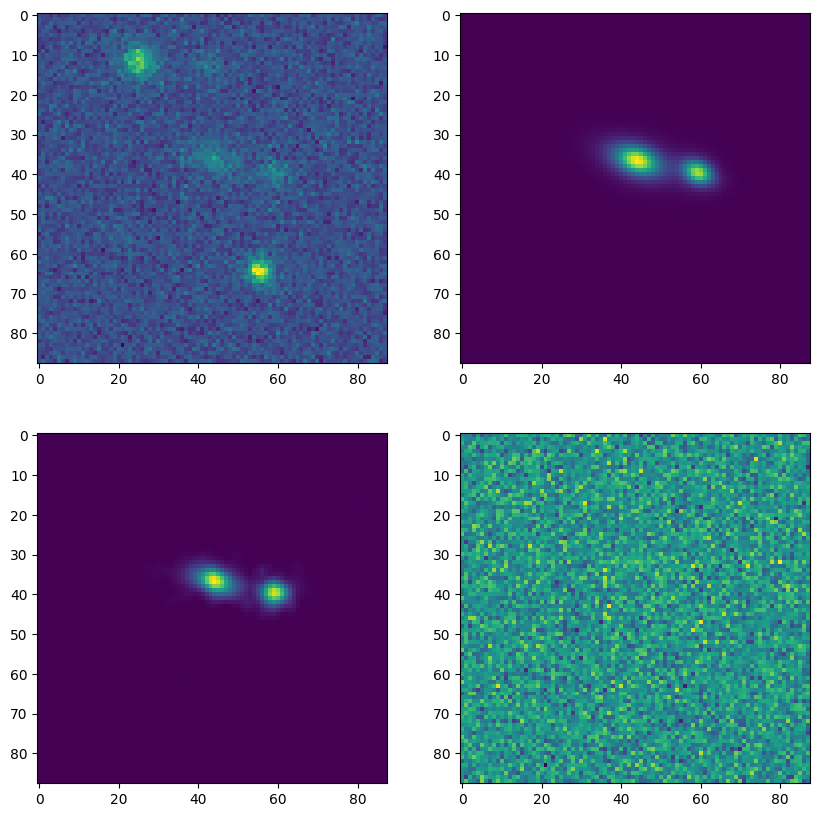

In [ ]:
idx = 39
fig, axes = plt.subplots(2,2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axes.flatten()

image = images[idx, 0].numpy()
ax1.imshow(image)

noiseless = galaxy_uncentered[idx, :, 0].sum(axis=(0)).numpy()
ax2.imshow(noiseless)

noiseless_recon = recon_uncentered[idx, :, 0].sum(axis=(0)).numpy()
ax3.imshow(noiseless_recon)

res = image - recon_uncentered[idx, :, 0].sum(axis=(0)).numpy() - paddings[idx, 0].numpy()
ax4.imshow(res)

print(truth['galaxy_bools'][idx, :, 0])


## Attempt ellipticities

In [ ]:
noisy_single = rearrange(images[:, 0]  - paddings[:, 0] - galaxy_uncentered[:, :, 0].sum(axis=1), 'n h w -> n 1 h w') + galaxy_uncentered[:, :, 0]

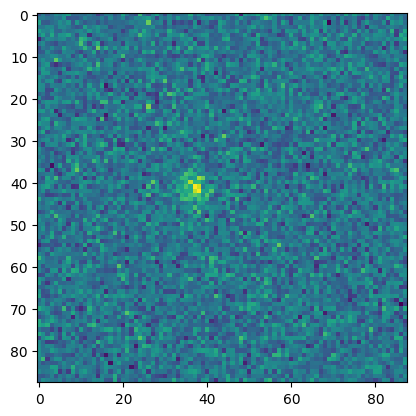

In [ ]:
plt.imshow(noisy_single[8, 0, :, :])

# Flux comparison with detections

In [ ]:
from bliss.encoder.detection import DetectionEncoder
# model
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_42_42.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False)